In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Concatenate, GaussianDropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.datasets import fashion_mnist

In [2]:
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
x_train=np.reshape(x_train, (-1,28,28,1))
x_test=np.reshape(x_test, (-1,28,28,1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [5]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [6]:
augmented_images = datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False)

x_train_augmented, y_train_augmented = next(augmented_images)

x_train = np.concatenate([x_train, x_train_augmented])
y_train = np.concatenate([y_train, y_train_augmented])

In [7]:
x_train = Concatenate()([x_train,x_train,x_train])
x_test = Concatenate()([x_test,x_test,x_test])

x_train.shape, x_test.shape

(TensorShape([120000, 28, 28, 3]), TensorShape([10000, 28, 28, 3]))

In [8]:
x_train = tf.image.resize(x_train, (32,32))
x_test = tf.image.resize(x_test, (32,32))

x_train.shape, x_test.shape

(TensorShape([120000, 32, 32, 3]), TensorShape([10000, 32, 32, 3]))

In [9]:
x_train = np.asarray([img_to_array(im) for im in x_train])
x_test = np.asarray([img_to_array(im) for im in x_test])

x_train.shape, x_test.shape

((120000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
train_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_generator = ImageDataGenerator(rescale=1./255)

train_generator.fit(x_train)
test_generator.fit(x_test)

traingen = train_generator.flow(x_train,y_train,batch_size=200)
testgen = test_generator.flow(x_test,y_test,batch_size=200)

In [11]:
conv_base = VGG16(include_top=False, input_shape=(150, 150, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block3_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
model = Sequential()
model.add(Lambda(lambda x: tf.image.resize(x, (150, 150))))
model.add(conv_base)
model.add(Flatten())
model.add(GaussianDropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.build((None, 150, 150, 3))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 gaussian_dropout (Gaussian  (None, 8192)              0         
 Dropout)                                                        
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [15]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate = 1e-4),
    metrics=["acc"]
)

In [16]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [17]:
lr_scheduler = LearningRateScheduler(scheduler)
callbacks = [lr_scheduler]

history = model.fit(traingen, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=testgen, callbacks=callbacks)

Epoch 1/10
600/600 [==============================] - 545s 853ms/step - loss: 0.6174 - acc: 0.7736 - val_loss: 0.2969 - val_acc: 0.8885 - lr: 1.0000e-04
Epoch 2/10
600/600 [==============================] - 510s 850ms/step - loss: 0.3977 - acc: 0.8544 - val_loss: 0.2537 - val_acc: 0.9085 - lr: 1.0000e-04
Epoch 3/10
600/600 [==============================] - 509s 848ms/step - loss: 0.3433 - acc: 0.8746 - val_loss: 0.2535 - val_acc: 0.9000 - lr: 1.0000e-04
Epoch 4/10
600/600 [==============================] - 508s 847ms/step - loss: 0.3096 - acc: 0.8867 - val_loss: 0.2234 - val_acc: 0.9186 - lr: 1.0000e-04
Epoch 5/10
600/600 [==============================] - 507s 844ms/step - loss: 0.2883 - acc: 0.8946 - val_loss: 0.2152 - val_acc: 0.9188 - lr: 1.0000e-04
Epoch 6/10
600/600 [==============================] - 507s 844ms/step - loss: 0.2733 - acc: 0.9002 - val_loss: 0.2210 - val_acc: 0.9207 - lr: 1.0000e-04
Epoch 7/10
600/600 [==============================] - 506s 843ms/step - loss: 0.25

In [21]:
def accuracy_and_loss_plots(history):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
    ax1.plot(history.history['val_acc'])
    ax1.set_title('Test Accuracy by Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(0.8,1)
    ax2.plot(history.history['loss'], label='Training loss')
    ax2.plot(history.history['val_loss'], label='Testing loss')
    ax2.set_title('Loss Reduction by Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(0,1)
    ax2.legend()

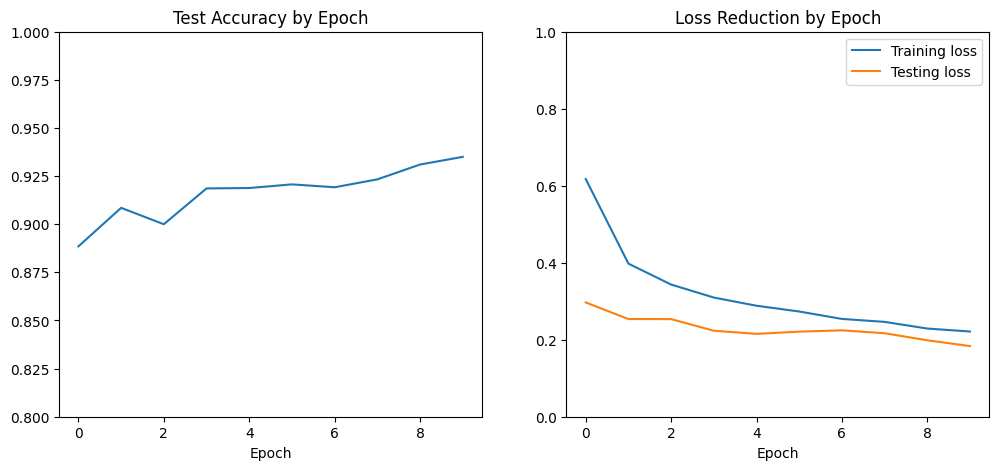

In [22]:
accuracy_and_loss_plots(history)

# Conclusion
In this home assignment, we created two convolutional neural networks, one with its own convolutional layer architecture, the other by training an existing convolutional neural network to classify images, and used imagenet weights. 

* Time of learning of the first CNN: 7200s  
* Time of learning of the second CNN: 5400s  
* Accuracy of the first CNN: 93%  
* Accuracy of the second CNN: 93.5%  